<a href="https://colab.research.google.com/github/vincentandaw/portfolio/blob/main/Python-Portfolio/PCA_and_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.datasets import load_breast_cancer
bcdat = load_breast_cancer()
X, y = bcdat.data, bcdat.target

random_state=14

In [ ]:
### Preprocessing ###

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#we create train and test data, then carve out validation data from train
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=random_state)

sc = StandardScaler()
X_train = sc.fit_transform(X_train) #fit_transform for train; only fit_transform train
X_valid = sc.transform(X_valid) #transform uses the parameters (e.g. mean, variance) learned by train
X_test = sc.transform(X_test) #transform uses the parameters (e.g. mean, variance) learned by train

In [ ]:
### Part 1a: PCA to get only five principal components ###

In [ ]:
pca5 = PCA(n_components = 5) #Number of PCs we want = 5
X_train_pca = pca5.fit_transform(X_train) #Fit it to model
X_test_pca = pca5.transform(X_test) #Transform (do not fit) the X_test (to do predictions later)
X_valid_pca = pca5.transform(X_valid)

variance_explained = np.sum(pca5.explained_variance_ratio_)
variance_explained #0.999

0.8541446051615719

In [ ]:
y_train.shape


(341,)

In [ ]:
### Part 1b: Do prediction on these five components only. I will use a simple random forest ###

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

RF = RandomForestClassifier(max_depth=2, random_state=random_state)
RF.fit(X_train_pca,y_train)

y_pred = RF.predict(X_test_pca)
for_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(for_rmse) #0.2294

0.22941573387056177


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RF, X_train_pca, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean()) #0.2464

0.27972711286174123


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[36  5]
 [ 1 72]]


In [ ]:
### Part 2: Fit Neural Network to predict "Malignant" (0) or "Benign" (1)

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
#Wide and Deep Neural Network Model

#Run input through two hidden layers
#then, combine input from two hidden layers with "fresh" input i.e. using input data twice
#concatenate the two data together for output

input_ = keras.layers.Input(shape=X_train_pca.shape[1:])
hidden1 = keras.layers.Dense(40, activation="relu")(input_)
hidden2 = keras.layers.Dense(20, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(10, activation="softmax")(hidden2) #adding this layer 
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat) 
model = keras.models.Model(inputs=[input_], outputs=[output])

In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 dense_43 (Dense)               (None, 40)           240         ['input_12[0][0]']               
                                                                                                  
 dense_44 (Dense)               (None, 20)           820         ['dense_43[0][0]']               
                                                                                                  
 concatenate_11 (Concatenate)   (None, 25)           0           ['input_12[0][0]',               
                                                                  'dense_44[0][0]']        

In [ ]:
model.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"]) 
history = model.fit(X_train_pca, y_train, epochs=30,validation_data=(X_valid_pca, y_valid))

Epoch 1/30
11/11 [==============================] - 1s 23ms/step - loss: 7.2901 - accuracy: 0.4164 - val_loss: 4.9620 - val_accuracy: 0.5526
Epoch 2/30
11/11 [==============================] - 0s 7ms/step - loss: 5.6675 - accuracy: 0.4721 - val_loss: 3.9611 - val_accuracy: 0.5702
Epoch 3/30
11/11 [==============================] - 0s 7ms/step - loss: 4.7425 - accuracy: 0.5660 - val_loss: 3.0602 - val_accuracy: 0.6140
Epoch 4/30
11/11 [==============================] - 0s 6ms/step - loss: 4.3524 - accuracy: 0.5982 - val_loss: 2.5998 - val_accuracy: 0.6754
Epoch 5/30
11/11 [==============================] - 0s 6ms/step - loss: 3.3845 - accuracy: 0.6628 - val_loss: 1.8352 - val_accuracy: 0.7368
Epoch 6/30
11/11 [==============================] - 0s 6ms/step - loss: 2.8259 - accuracy: 0.7155 - val_loss: 1.2258 - val_accuracy: 0.8070
Epoch 7/30
11/11 [==============================] - 0s 6ms/step - loss: 2.2778 - accuracy: 0.7595 - val_loss: 1.0421 - val_accuracy: 0.8246
Epoch 8/30
11/11 [=

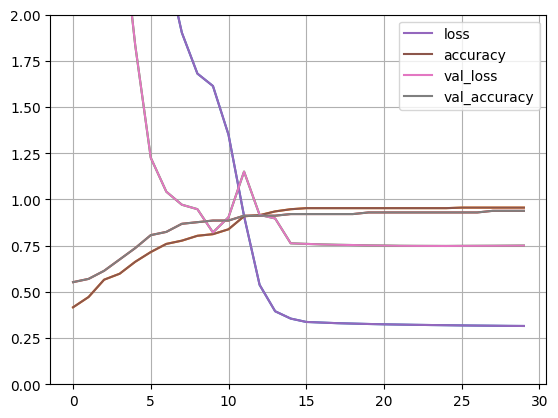

In [ ]:
metrics = pd.DataFrame(history.history)
plt.plot(metrics)
for col in ('loss', 'accuracy','val_loss','val_accuracy'):
    metrics[col].plot(legend=True)
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [ ]:
### Adding PCA created those val_loss spikes at epoch 12. Val_loss plateau also detected after epoch 15, but it does not flatline.

In [ ]:
mse_test = model.evaluate(X_test_pca, y_test)
y_pred_NN = model.predict(X_test_pca)
print(y_pred_NN.min(),y_pred_NN.max())

4/4 [==============================] - 0s 3ms/step
-5.76038 8.062515


In [ ]:
### Testing: No PCA ###

In [ ]:
#Wide and Deep Neural Network Model

#Run input through two hidden layers
#then, combine input from two hidden layers with "fresh" input i.e. using input data twice
#concatenate the two data together for output

input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(40, activation="relu")(input_)
hidden2 = keras.layers.Dense(20, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(10, activation="softmax")(hidden2)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat) 
model = keras.models.Model(inputs=[input_], outputs=[output])

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 dense_47 (Dense)               (None, 40)           1240        ['input_13[0][0]']               
                                                                                                  
 dense_48 (Dense)               (None, 20)           820         ['dense_47[0][0]']               
                                                                                                  
 concatenate_12 (Concatenate)   (None, 50)           0           ['input_13[0][0]',               
                                                                  'dense_48[0][0]']        

In [ ]:
model.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"]) 
history = model.fit(X_train, y_train, epochs=30,validation_data=(X_valid, y_valid))

Epoch 1/30
11/11 [==============================] - 1s 25ms/step - loss: 7.1708 - accuracy: 0.3372 - val_loss: 5.9041 - val_accuracy: 0.3684
Epoch 2/30
11/11 [==============================] - 0s 7ms/step - loss: 4.2489 - accuracy: 0.5337 - val_loss: 2.6247 - val_accuracy: 0.6667
Epoch 3/30
11/11 [==============================] - 0s 6ms/step - loss: 2.6559 - accuracy: 0.6540 - val_loss: 2.1239 - val_accuracy: 0.7368
Epoch 4/30
11/11 [==============================] - 0s 7ms/step - loss: 2.1590 - accuracy: 0.7067 - val_loss: 1.4014 - val_accuracy: 0.7982
Epoch 5/30
11/11 [==============================] - 0s 7ms/step - loss: 1.1481 - accuracy: 0.7947 - val_loss: 1.0652 - val_accuracy: 0.8333
Epoch 6/30
11/11 [==============================] - 0s 8ms/step - loss: 0.8238 - accuracy: 0.8299 - val_loss: 1.0047 - val_accuracy: 0.8509
Epoch 7/30
11/11 [==============================] - 0s 7ms/step - loss: 0.6523 - accuracy: 0.8622 - val_loss: 0.9660 - val_accuracy: 0.8772
Epoch 8/30
11/11 [=

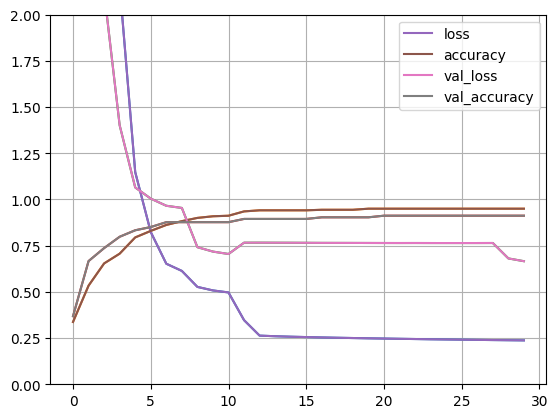

In [ ]:
metrics_noPCA = pd.DataFrame(history.history)
plt.plot(metrics_noPCA)
for col in ('loss', 'accuracy','val_loss','val_accuracy'):
    metrics_noPCA[col].plot(legend=True)
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()